<a href="https://colab.research.google.com/github/antonioenas/Denoising_HPatches_for_Descriptor_Learning/blob/master/Complete_evaluation_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction - Deep learning coursework, Imperial College London
**Antonio Enas, 01070859, AE1115**


---

In this notebook, the user can load trained denoiser and descriptor models to evaluate their performance.

For qualitative evaluation, we propose the *joint hex plot* of the pairwise distances (anchor to positive and anchor to negative).
Furthermore, the validation set can be plotted in 2 dimensions with the respetive labels.

Structure:
1. Environment set up
2. Load pre trained models
3. Qualitative evaluation
4. Quantitative evaluation

# 1. Environment set up
This section ensures all libraries and dataset are correctly imported.

If data is already mounted select:
              `import_data = False`

In [0]:
import_data = True

### Optional GPU check

In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  printm()

### Cloning the repository and downloading the data

In [0]:
if import_data == False:
  # Change directory
  %cd /content/keras_triplet_descriptor
else:
  # Clone repo
  !git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
  %cd /content/keras_triplet_descriptor
  # Download data
  !wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
  # Extract data
  !unzip -q ./hpatches_data.zip
  !rm ./hpatches_data.zip


Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 181 (delta 0), reused 1 (delta 0), pack-reused 178
Receiving objects: 100% (181/181), 149.87 MiB | 22.47 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (69/69), done.
/content/keras_triplet_descriptor
--2019-03-26 12:29:04--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.27.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-26 12:29:04--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing con

### Importing Necessary Modules

In [0]:
!pip install -U seaborn

import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams["patch.force_edgecolor"] = True

# To download files
from google.colab import files

from sklearn.decomposition import PCA
import pandas as pd

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


# 2. Upload and load models to evaluate
Parameters needed:

*    `use_clean_bool` to evaluate using noisy or clean patches
*   `denoiser_to_eval`
*   `descripto_to_eval`

In [0]:
use_clean_bool = True

In [0]:
denoiser_to_eval = None

In [0]:
descriptor_notrip_eval = keras.models.load_model('./bs_c_descriptor_e20.h5')
descriptor_trip_eval = keras.models.load_model('./bs_c_trip_descriptor_e20.h5')

# 3. Qualitative evaluation
In this section we visualise the individual pair distances within each triplet onto the loss surface and the respective  loss distribiution.

### Generate the evaluation triplets for both qualitative and quantitative evaluation

In [0]:
hPatches = HPatches(train_fnames=train_fnames, denoise_model=denoiser_to_eval, test_fnames=test_fnames, use_clean=use_clean_bool)

In [0]:
# Specify how many triplets to consider
n_triplets = 100000

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)
# Generate a single large batch of triplets in the training set
#eval_test_gen = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir,train=0), batch_size=n_triplets, num_triplets=n_triplets)
eval_test_gen = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir,train=0), batch_size=50, num_triplets=10000)


Using clean patches
100%|██████████| 116/116 [00:20<00:00,  3.27it/s]


100%|██████████| 10000/10000 [00:00<00:00, 60301.20it/s]


In [0]:
# Lossless triplet model to generate triplets for plots
shape = (32,32,1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')

ea = descriptor_notrip_eval(xa)
ep = descriptor_notrip_eval(xp)
en = descriptor_notrip_eval(xn)

eval_triplet = Model(inputs=[xa, xp, xn], outputs=[ea, ep, en])

## Calculate the distance between positive and negative descriptor pairs

Calculate the euclidean distance between AP, AN pairs. Then evaluate how the distance pairs are distributed onto the loss surface.

In [0]:
# Extract the triplets packed in the generator
#a = next(iter(eval_test_gen))
#embedding_p = descriptor_to_eval.predict(a[0]['p'])
#embedding_n = descriptor_to_eval.predict(a[0]['n'])

In [0]:
# Generate the descriptor vectors for each anchor, positive and negative image
embedding_a, embedding_p, embedding_n = eval_triplet.predict_generator(eval_test_gen)

# Measure distances between triplets
positive_distance = np.mean((embedding_a-embedding_p)**2 , axis=-1)
negative_distance = np.mean((embedding_a-embedding_n)**2 , axis=-1)

100%|██████████| 10000/10000 [00:00<00:00, 61045.97it/s]


In [0]:
# Extract labels of each descriptor

a_labels = np.zeros((np.shape(eval_test_gen.triplets)[0],))
p_labels = np.zeros((np.shape(eval_test_gen.triplets)[0],))
n_labels = np.zeros((np.shape(eval_test_gen.triplets)[0],))

i = 0
for idx in eval_test_gen.triplets:
  a_labels[i] = eval_test_gen.labels[idx[0]]
  p_labels[i] = eval_test_gen.labels[idx[1]]
  n_labels[i] = eval_test_gen.labels[idx[2]]
  i += 1

In [0]:
vector_map = np.array([embedding_a, embedding_p, embedding_n ]).reshape(3*np.shape(eval_test_gen.triplets)[0],128)
labels_map = np.array([a_labels, p_labels, n_labels ]).reshape(3*np.shape(eval_test_gen.triplets)[0],)

In [0]:
# Create dataframe to contain the results
df = pd.DataFrame(vector_map)
df['label'] = labels_map

In [0]:
df

In [0]:
# Visualisethrough PCA



pca = PCA(n_components=20)
pca_result = pca.fit_transform(vector_map)


print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)

Explained variation per principal component: [0.16084184 0.11599272 0.09349535 0.07275984 0.06397235 0.05263386
 0.04428929 0.04288212 0.04141132 0.03650151 0.02843161 0.02745365
 0.02556002 0.02060966 0.01929176 0.01862704 0.01688718 0.01426496
 0.01398589 0.01132978]


In [0]:
# Load results in Pandas to ease visualisation
df = pd.DataFrame(pca_result)
df['label'] = labels_map


In [0]:
df.sort_values(by= 'label')

df['count'] = \
df.groupby('label')['label']\
  .transform(pd.Series.value_counts)
df.sort_values('count', inplace=True, ascending=False)
df.drop('count', axis=1, inplace = True)

In [0]:
select_few_labels = np.unique()

In [0]:
unique, counts = np.unique(df['label'], return_counts=True)


In [0]:
counts

array([1, 1, 1, ..., 2, 1, 1])

In [0]:
unique

array([1.0000e+00, 8.0000e+00, 1.0000e+01, ..., 5.9524e+04, 5.9528e+04,
       5.9530e+04])

In [0]:
df[:30]

,PC1,PC2,PC3,label
13184,10.760157,2.861496,8.296907,56700.0
6155,1.390484,0.852753,5.830827,48884.0
10537,-9.006827,-4.299463,-2.905126,48884.0
16155,1.000165,0.905717,4.839370,48884.0
3184,9.465297,-0.062436,9.793715,56700.0
16154,-4.812061,3.478167,-14.940353,56700.0
16821,6.367405,-2.412194,-1.126285,48884.0
537,3.275737,2.414658,0.076900,48884.0
24160,4.243713,-2.986864,6.956008,48884.0
29899,-10.542496,7.908948,1.539736,48884.0


In [0]:
np.shape(np.unique(labels_map))

(200,)

In [0]:
facet = sns.scatterplot(data=df[:30], x='PC1', y='PC2', hue='label')


In [0]:
import time

from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(df.values)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.061s...
[t-SNE] Computed neighbors for 30000 samples in 1.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sa

In [0]:
df_tsne = df.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

In [0]:
sns.set_style('ticks')
plt.figure(figsize=(5,5))
facet = sns.scatterplot(data=df_tsne, x='x-tsne', y='y-tsne', hue='label')
facet.labels("$x-tsne$", "$y-tsne$",fontsize=18)

AttributeError: ignored

<Figure size 144x360 with 0 Axes>

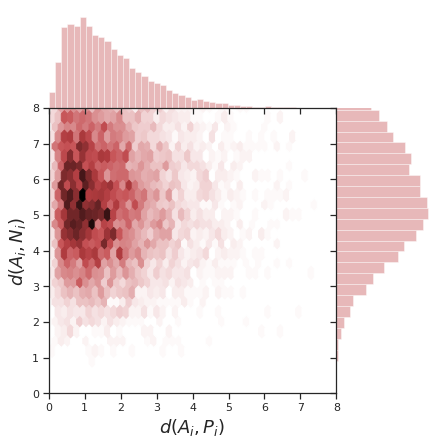

In [0]:
# Plot distance distribution
sns.set_style('ticks')
plt.figure(figsize=(2,5))
g = (sns.jointplot(x=positive_distance, y=negative_distance, kind="hex",color = 'r',
                   xlim = (0,8), ylim = (0,8), ratio = 3, space=0)
     .set_axis_labels("$d(A_i,P_i)$", "$d(A_i,N_i)$",fontsize=18))
g.ax_joint.legend_.remove()
g.fig.suptitle('Pairwise distances \n Hardnet 1 epoch (noisy)', fontsize=20)
g.ax_joint.plot([0,8], [0,8], 'k',linewidth = 1)

# Evaluation section

## Generating descriptors files for test data 

To evaluate the performance of out model we use the existing evaluation code  **HPatches benchmark**, which generates a .csv and then compute the three benchmarking metrics.

In [0]:
generate_desc_csv(descripto_to_eval, seqs_test, denoise_model=denoiser_to_eval, use_clean = use_clean_bool)

## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model.

### Verification

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification


### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching


### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval